In [4]:
import os
import random
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    torch.manual_seed(SEED)
except Exception:
    pass

In [1]:
train_df = pd.read_csv('train.tsv', sep='\t', header=None)
valid_df = pd.read_csv('valid.tsv', sep='\t', header=None)
test_df = pd.read_csv('test.tsv', sep='\t', header=None)

cols = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts', 'context']

train_df.columns = valid_df.columns = test_df.columns = cols

data = pd.concat([train_df, valid_df])

X = data['statement'].astype(str)
y = data['label']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=40, padding='post', truncating='post')

# ====== 4. Крос-валідація ======
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_acc = []

for train_index, val_index in kf.split(X_padded):
    X_train, X_val = X_padded[train_index], X_padded[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    model = Sequential([
        Embedding(10000, 64, input_length=40),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(len(encoder.classes_), activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_val, y_val), verbose=1)

    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    fold_acc.append(val_acc)

print(f"Average LSTM accuracy from 3-fold CV: {np.mean(fold_acc):.3f}")


D:\python\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.1999 - loss: 1.7742 - val_accuracy: 0.2119 - val_loss: 1.7557
Epoch 2/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1979 - loss: 1.7648 - val_accuracy: 0.2225 - val_loss: 1.7544
Epoch 3/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2062 - loss: 1.7640 - val_accuracy: 0.2108 - val_loss: 1.7508
Epoch 1/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.1929 - loss: 1.7719 - val_accuracy: 0.2065 - val_loss: 1.7670
Epoch 2/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1925 - loss: 1.7639 - val_accuracy: 0.1966 - val_loss: 1.7660
Epoch 3/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2007 - loss: 1.7608 - val_accuracy: 0.1966 - val_loss: 1.7656
Epoch 1/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.1965 - loss: 1.7721 - val_accuracy: 0.2065 - val_loss: 1.7582
Epoch 2/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1959 - loss: 1.7615 - val_accuracy: 0.

Train set: (10240, 14)
Validation set: (1284, 14)
Test set: (1267, 14)


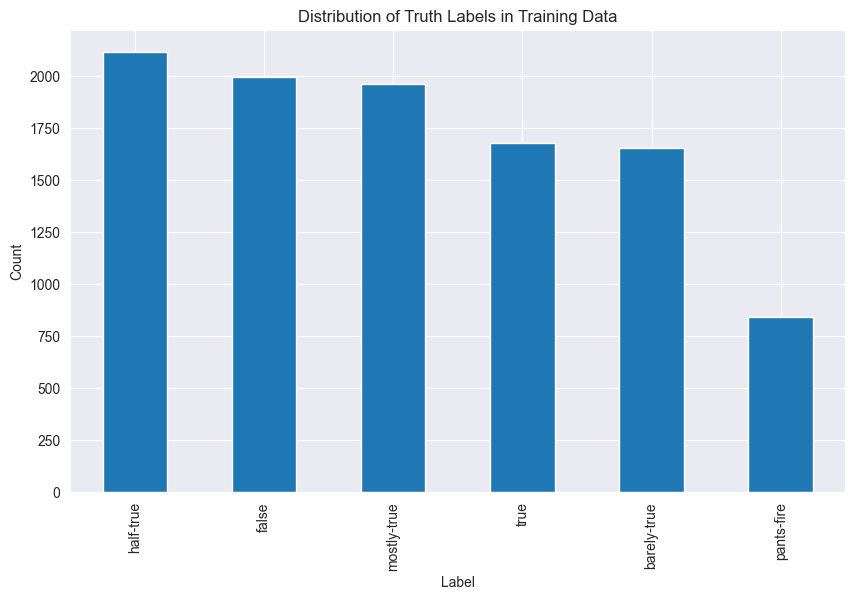

,file,label,statement,subject,speaker,job_title,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [2]:
print(f"Train set: {train_df.shape}")
print(f"Validation set: {valid_df.shape}")
print(f"Test set: {test_df.shape}")

plt.figure(figsize=(10, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Truth Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

train_df.head()

In [3]:
binary_label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 0,
    'mostly-true': 1,
    'true': 1
}

train_df['binary_label'] = train_df['label'].map(binary_label_map)
valid_df['binary_label'] = valid_df['label'].map(binary_label_map)
test_df['binary_label']  = test_df['label'].map(binary_label_map)

X_train_texts = train_df['statement'].astype(str).tolist()
y_train = np.array(train_df['binary_label'].astype(int).tolist())

X_val_texts = valid_df['statement'].astype(str).tolist()
y_val = np.array(valid_df['binary_label'].astype(int).tolist())

X_test_texts = test_df['statement'].astype(str).tolist()
y_test = np.array(test_df['binary_label'].astype(int).tolist())

VOCAB_SIZE = 20000
MAX_LEN = 80

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)  # fit on train only
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_val_seq   = tokenizer.texts_to_sequences(X_val_texts)
X_test_seq  = tokenizer.texts_to_sequences(X_test_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("Train label counts:", np.unique(y_train, return_counts=True))
print("Class weight mapping:", class_weight)

EMBED_DIM = 128
LSTM_UNITS = 128

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')   # binary
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)

val_probs = model.predict(X_val_pad, batch_size=256, verbose=0).flatten()
best_t, best_f1 = 0.5, 0.0
for t in np.linspace(0.1, 0.9, 17):
    preds = (val_probs >= t).astype(int)
    f = f1_score(y_val, preds, average='binary')
    if f > best_f1:
        best_f1, best_t = f, t
print(f"Best val F1 {best_f1:.4f} at threshold {best_t:.2f}")

test_probs = model.predict(X_test_pad, batch_size=256, verbose=0).flatten()
test_preds = (test_probs >= best_t).astype(int)

print("Test classification report:")
print(classification_report(y_test, test_preds, digits=4))

print(f"Overall F1 (binary / micro / macro / weighted):")
print(f"  binary   : {f1_score(y_test, test_preds, average='binary'):.4f}")
print(f"  micro    : {f1_score(y_test, test_preds, average='micro'):.4f}")
print(f"  macro    : {f1_score(y_test, test_preds, average='macro'):.4f}")
print(f"  weighted : {f1_score(y_test, test_preds, average='weighted'):.4f}")

Train label counts: (array([0, 1]), array([6602, 3638], dtype=int64))
Class weight mapping: {0: 0.7755225689185096, 1: 1.4073666849917537}


D:\python\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
160/160 - 16s - 98ms/step - accuracy: 0.4946 - loss: 0.6940 - val_accuracy: 0.6729 - val_loss: 0.6917
Epoch 2/10
160/160 - 9s - 57ms/step - accuracy: 0.4826 - loss: 0.6936 - val_accuracy: 0.6729 - val_loss: 0.6908
Epoch 3/10
160/160 - 11s - 69ms/step - accuracy: 0.5282 - loss: 0.6934 - val_accuracy: 0.6729 - val_loss: 0.6925
Epoch 4/10
160/160 - 9s - 57ms/step - accuracy: 0.4768 - loss: 0.6932 - val_accuracy: 0.6729 - val_loss: 0.6927
Epoch 5/10
160/160 - 10s - 64ms/step - accuracy: 0.5145 - loss: 0.6937 - val_accuracy: 0.6729 - val_loss: 0.6903
Epoch 6/10
160/160 - 9s - 56ms/step - accuracy: 0.5211 - loss: 0.6933 - val_accuracy: 0.3271 - val_loss: 0.6940
Epoch 7/10
160/160 - 9s - 54ms/step - accuracy: 0.4363 - loss: 0.6932 - val_accuracy: 0.3271 - val_loss: 0.6938
Epoch 8/10
160/160 - 9s - 55ms/step - accuracy: 0.4375 - loss: 0.6931 - val_accuracy: 0.3271 - val_loss: 0.6935
Best val F1 0.4930 at threshold 0.10
Test classification report:
              precision    recall  f

D:\python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
def binarize_labels(df):
    df['binary_label'] = df['label'].apply(lambda x: 1 if x in ['true', 'mostly-true'] else 0)
    return df

train_df = binarize_labels(train_df)
valid_df = binarize_labels(valid_df)
test_df = binarize_labels(test_df)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])


pipeline.fit(train_df['statement'], train_df['binary_label'])

valid_pred = pipeline.predict(valid_df['statement'])
print("Validation accuracy:", accuracy_score(valid_df['binary_label'], valid_pred))
print(classification_report(valid_df['binary_label'], valid_pred))

Validation accuracy: 0.660436137071651
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       864
           1       0.48      0.58      0.53       420

    accuracy                           0.66      1284
   macro avg       0.63      0.64      0.63      1284
weighted avg       0.68      0.66      0.67      1284



In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_texts = train_df['statement'].tolist()
train_labels = train_df['binary_label'].tolist()
valid_texts = valid_df['statement'].tolist()
valid_labels = valid_df['binary_label'].tolist()
full_texts = train_texts + valid_texts
full_labels = train_labels + valid_labels

full_encodings = tokenizer(full_texts, truncation=True, padding=True, max_length=128)

class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

full_dataset = FakeNewsDataset(full_encodings, full_labels)

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = class_weights.to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
counts = Counter(full_labels)
class_weights = torch.tensor([1.0 / counts[i] for i in sorted(counts.keys())])

training_args = TrainingArguments(
    output_dir=f'./results_full',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir=f'./logs_full',
    logging_steps=50,
    save_steps=200,
    fp16=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=full_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

trainer.train()
print("Тренування завершено")
test_texts = test_df['statement'].tolist()
test_labels = test_df['binary_label'].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)
test_dataset = FakeNewsDataset(test_encodings, test_labels)
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("\nРезультати на тестовому датасеті:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1: {test_results['eval_f1']:.4f}")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\38095\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\38095\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

c:\Users\38095\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2163 [00:00<?, ?it/s]

{'loss': 0.6927, 'grad_norm': 1.2743430137634277, 'learning_rate': 1.25e-05, 'epoch': 0.07}
{'loss': 0.6829, 'grad_norm': 1.707743763923645, 'learning_rate': 2.5e-05, 'epoch': 0.14}
{'loss': 0.6749, 'grad_norm': 4.705739974975586, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.21}
{'loss': 0.6631, 'grad_norm': 2.6045236587524414, 'learning_rate': 5e-05, 'epoch': 0.28}
{'loss': 0.6741, 'grad_norm': 1.7820037603378296, 'learning_rate': 4.872643912379012e-05, 'epoch': 0.35}
{'loss': 0.683, 'grad_norm': 1.5691293478012085, 'learning_rate': 4.745287824758024e-05, 'epoch': 0.42}
{'loss': 0.6575, 'grad_norm': 1.9074976444244385, 'learning_rate': 4.6179317371370354e-05, 'epoch': 0.49}
{'loss': 0.6662, 'grad_norm': 3.409620761871338, 'learning_rate': 4.490575649516047e-05, 'epoch': 0.55}
{'loss': 0.6605, 'grad_norm': 1.77568519115448, 'learning_rate': 4.363219561895059e-05, 'epoch': 0.62}
{'loss': 0.6708, 'grad_norm': 2.101933002471924, 'learning_rate': 4.2358634742740705e-05, 'epoch': 0.6

  0%|          | 0/40 [00:00<?, ?it/s]


Результати на тестовому датасеті:
Accuracy: 0.6212
F1: 0.6690
Precision: 0.6590
Recall: 0.6793
